## Begin construction of 35N AMOC time series

This code begins construction, stitches datasets together and saves the full section output. Next steps will include addition of Ekman and throughflow/closure.

In [1]:
%matplotlib inline
import xarray as xr

In [2]:
from xgcm import Grid
from pylab import *
import seawater as sw
import gsw
import scipy.signal as sig
from xhistogram.xarray import histogram

In [3]:
from dask.distributed import Client,progress
from dask_gateway import Gateway

In [4]:
client = Client(n_workers=30,threads_per_worker=20,memory_limit='180GB')

In [5]:
basedir='/vortexfs1/home/ilebras/'
datadir=basedir+'data/'

In [6]:
xray=xr.open_dataset(datadir+'Willis/ilebras/Willis_allvars_Aug2022.nc',chunks={})

Calculate meridional geostrophic velocity

In [7]:
rho0=1030

In [8]:
xray=xray.rename({'den':'dmap'})

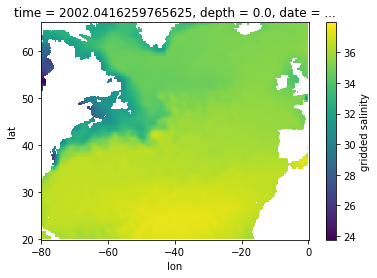

In [9]:
xray.sal.isel(depth=0).isel(date=0).plot()

In [10]:
def get_geovel(xray):
    xray=xray.assign_coords(loni=xray.lon.values[:-1]+diff(xray.lon.values)/2)
    lonmat,latmat=meshgrid(xray.lon,xray.lat)
    xray['distdiff']=(['lat','loni'],gsw.distance(lonmat,latmat))
    xray['fcor']=(['lat'],sw.f(xray.lat))
    #shear
    xray['drho_base']=(['depth','lat','loni','date'],xray['dmap'].where(xray.depth<-xray.bathy).diff(dim='lon'))
    shear=xray['drho_base']*9.8/xray.fcor/rho0/xray.distdiff
    print(shear)
    xray['depthdiff']=(['depth'],hstack((5,xray.depth.diff(dim='depth'))))
    geovel=(shear*xray.depthdiff).cumsum(dim='depth')
    # reference velocity
    xray['velref']=(['lat','loni','date'],(xray.vmap+xray.vmap.diff(dim='lon')/2))
    xray['vg']=(['depth','lat','loni','date'],geovel+(xray.velref-geovel.sel(depth=1000)))
    xray['area']=xray['depthdiff']*xray['distdiff']
    xray['trans']=(xray['vg']*xray['area'])/1e6
    return xray

xray=get_geovel(xray)

<xarray.DataArray (depth: 201, lat: 185, loni: 320, date: 240)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 5.03754608e-0

cut out the med - go back to limiting time period as a test!

In [11]:
start_date='2004-5-1'
end_date='2014-5-1'

In [12]:
xray=xray.sel(loni=slice(-80,-6)).sel(lon=slice(-80,-6)).sel(date=slice(start_date,end_date))

In [13]:
xray

<xarray.Dataset>
Dimensions:    (date: 120, depth: 201, lat: 185, lon: 297, loni: 296)
Coordinates:
    time       (date) float64 dask.array<chunksize=(120,), meta=np.ndarray>
  * lon        (lon) float32 -80.0 -79.75 -79.5 -79.25 ... -6.75 -6.5 -6.25 -6.0
  * lat        (lat) float32 20.0 20.25 20.5 20.75 ... 65.25 65.5 65.75 66.0
  * depth      (depth) float32 0.0 10.0 20.0 30.0 ... 1.98e+03 1.99e+03 2e+03
  * date       (date) datetime64[ns] 2004-05-16T23:15:00 ... 2014-04-17T12:23...
  * loni       (loni) float32 -79.88 -79.62 -79.38 ... -6.625 -6.375 -6.125
Data variables: (12/18)
    sal        (depth, lat, lon, date) float32 dask.array<chunksize=(201, 185, 297, 120), meta=np.ndarray>
    tmp        (depth, lat, lon, date) float32 dask.array<chunksize=(201, 185, 297, 120), meta=np.ndarray>
    dmap       (depth, lat, lon, date) float32 dask.array<chunksize=(201, 185, 297, 120), meta=np.ndarray>
    bathy      (lat, lon) float32 dask.array<chunksize=(185, 297), meta=np.ndarray>
    sshu       (lat, lon, date) float32 dask.array<chunksize=(185, 297, 120), meta=np.ndarray>
    sshv       (lat, lon, date) float32 dask.array<chunksize=(185, 297, 120), meta=np.ndarray>
    ...         ...
    drho_base  (depth, lat, loni, date) float32 nan nan nan nan ... nan nan nan
    depthdiff  (depth) float64 5.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    velref     (lat, loni, date) float32 nan nan nan nan nan ... nan nan nan nan
    vg         (depth, lat, loni, date) float64 nan nan nan nan ... nan nan nan
    area       (depth, lat, loni) float64 1.306e+05 1.306e+05 ... 1.131e+05
    trans      (depth, lat, loni, date) float64 nan nan nan nan ... nan nan nan
Attributes:
    long_name:  gridded salinity
    Units:      psu

In [14]:
theta=pi*60/180

LWsel = Willis properties extracted along LW line

In [15]:
LW=xr.open_dataset(datadir+'LineW/LineW_moorings_dailygridded_April2021.nc')

Start extraction from Line W origin

In [16]:
#line along the Line W path:
m=(LW.lat[4]-LW.lat[0])/(LW.lon[4]-LW.lon[0])
c=LW.lat[0]-m*LW.lon[0]
LWsel=xr.Dataset()
LWsel=LWsel.assign_coords({'xind':range(73),'xind_i':range(74),'date':xray.date,'depth':xray.depth})
lonstp=0.1
LWsel['loni']= (['xind'],(arange(LW.lon_origin,-63,lonstp)))
LWsel['lati']=(['xind'],(float(m)*LWsel.loni+float(c)))
latstp=mean(diff(LWsel['lati']))
LWsel['lon']= (['xind_i'],hstack((LWsel.loni[0]-lonstp/2,LWsel.loni[:-1]+lonstp/2,LWsel.loni[-1]+lonstp/2)))
LWsel['lat']=(['xind_i'],hstack((LWsel.lati[0]-latstp/2,LWsel.lati[:-1]+latstp/2,LWsel.lati[-1]+latstp/2)))

Get geovel across Line W section

Note: Counterintuitively, xind and xind_i correspond to loni and lon, respectively (because of coding laziness)

In [17]:
LWsel['sigma2_i']=(['depth','xind','date'],xray['sigma2'].interp(lon=LWsel.loni,lat=LWsel.lati))
LWsel['bathy_i']=(['xind'],xray['bathy'].interp(lon=LWsel.loni,lat=LWsel.lati))
LWsel['rho_i']=(['depth','xind','date'],(xray['dmap']+1e3).interp(lon=LWsel.loni,lat=LWsel.lati))

In [18]:
LWsel['dmap']=(['depth','xind_i','date'],xray['dmap'].interp(lon=LWsel.lon,lat=LWsel.lat))#.where(xray.mask==1)
# LWsel['maski']=(['depth','xind'],xray['maski'].interp(loni=LWsel.loni,lat=LWsel.lati))
LWsel['distdiff']=(['xind'],gsw.distance(LWsel.lon.values,LWsel.lat.values))
LWsel['drho_base']=(['depth','xind','date'],LWsel['dmap'].diff(dim='xind_i'))
LWsel['fcor']=(['xind'],sw.f(LWsel.lati))
shear=LWsel['drho_base']*9.8/LWsel.fcor/rho0/LWsel.distdiff
geovel=(shear*xray.depthdiff).cumsum(dim='depth')
# reference velocity
uref=xray.umap.interp(lon=LWsel.loni,lat=LWsel.lati)#.where(xray.mask==1)
vref=xray.vmap.interp(lon=LWsel.loni,lat=LWsel.lati)#.where(xray.mask==1)

In [19]:
vtot_ref=uref*sin(theta)+vref*cos(theta)
LWsel['velref']=(['xind','date'],vtot_ref)
LWsel['vg']=(['depth','xind','date'],(geovel+LWsel.velref-geovel.sel(depth=1000)).where(LWsel.depth<-LWsel.bathy_i))#.where(LWsel.maski==1))
LWsel['area']=xray['depthdiff']*LWsel['distdiff']
LWsel['trans']=(LWsel['vg']*LWsel['area'])/1e6

In [20]:
#quick addition necessary for stitching together
xray['sigma2_i']=xray['sigma2'].interp(lon=xray.loni)
xray['bathy_i']=xray['bathy'].interp(lon=xray.loni)
xray['rho_i']=(xray['dmap']+1e3).interp(lon=xray.loni)

LWSEC = just the portion I need to stich to zonal section

In [21]:
#choosing lat=35, as its least noisy - away from eddy field
latsel=35

In [22]:
#get longitude intersection for a given cut-across latitude
def get_lonx(latch):
    lonx_var=LW.lon[0]+(LW.lon[4]-LW.lon[0])*(latch-LW.lat[0])/(LW.lat[4]-LW.lat[0])
    return lonx_var

In [23]:
(arctan(abs(LW.lat[4]-LW.lat[0])/abs(LW.lon[4]-LW.lon[0]))+pi/2)*180/pi

<xarray.DataArray ()>
array(144.45693383)

In [24]:
lonsel=get_lonx(latsel)

In [25]:
# a lot of re-jiggering to match xray nomenclature
LWSEC=LWsel.set_coords('loni').set_coords('lati').swap_dims({'xind':'lati'}).sel(lati=slice(41,latsel)).drop('xind').swap_dims({'lati':'loni'})

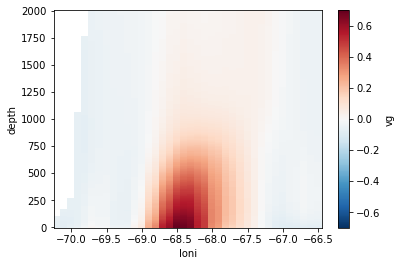

In [26]:
LWSEC.vg.mean(dim='date').plot()

LWplus = LW extraction stitched to zonal section (Still all Willis product)

In [27]:
LWplus=xr.Dataset()
for var in ['vg','sigma2_i','loni','bathy_i','rho_i']:
    LWplus[var]=xr.concat([LWSEC.drop('lati')[var],xray.sel(lat=latsel)[var].sel(loni=slice(lonsel,-6))],dim='loni',coords='minimal')
# LWplus['bathy_i']=LWplus['bathy_i'].isel(depth=0)
LWplus['depthdiff']=xray['depthdiff']

In [28]:
LWplus['lat']=(['loni'],hstack((LWSEC['lati'],latsel*ones(len(LWplus.loni)-len(LWSEC.lati)))))

(-70.0, -62.0)

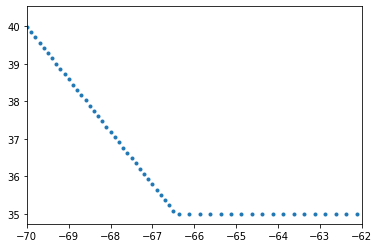

In [29]:
plot(LWplus.loni,LWplus.lat,'.')
xlim(-70,-62)

In [30]:
# join the distdiff correctly at the juncture:
xrdist1=LWSEC['distdiff']
xrdist2=xray['distdiff'].sel(lat=latsel).sel(loni=slice(lonsel,0))
joint_dist=gsw.distance([xrdist1.loni[-1],lonsel,xrdist2.loni[0]],[xrdist1.lati[-1],latsel,latsel])
xrdist1_corr=xrdist1.copy()
xrdist1_corr[-1]=xrdist1[-1]/2+joint_dist[0]
xrdist2_corr=xrdist2.copy()
xrdist2_corr[0]=xrdist2[0]/2+joint_dist[1]
LWplus['distdiff']=xr.concat([xrdist1_corr.drop('lati'),xrdist2_corr],dim='loni')
distdiff_i=(LWplus.distdiff[0:]+LWplus.distdiff[:-1])/2
LWplus['dist']=('loni',hstack((0,cumsum(distdiff_i)/1e3)))
LWplus=LWplus.swap_dims({'loni':'dist'})
LWplus['trans']=LWplus['vg']*LWplus['depthdiff']*LWplus['distdiff']/1e6

Combine Willis and LW data

but first... smooth the Line W data

In [31]:
def smoothfunc(tseries):
   # Design the Buterworth filter
    ## 2nd order 3 month default filter
    N  = 2    # Filter order
    Wn = 1/(365.25/4) # Cutoff frequency (3 months)
    B, A = sig.butter(N, Wn, output='ba')
    tseries_sm=sig.filtfilt(B,A,tseries)
    return tseries_sm

LW_sm=xr.Dataset()
# focus on w1-w5 and remove any times with no data
#note: max depth needs to be deep enough for the full basin
LW_10m=LW.interp(depth=arange(0,5600,10)).isel(dist=slice(0,5)).dropna(dim='date',how='all')
LW_vg_sm=xr.apply_ufunc(smoothfunc,LW_10m.vg)
LW_sig2_sm=xr.apply_ufunc(smoothfunc,LW_10m.sigma2)
LW_rho_sm=xr.apply_ufunc(smoothfunc,LW_10m.rho)
LW_sm['vg']=LW_vg_sm.interp(date=LWplus.date)
LW_sm['sigma2_i']=LW_sig2_sm.interp(date=LWplus.date)
LW_sm['rho_i']=LW_rho_sm.interp(date=LWplus.date)
LW_sm['depthdiff']=(['depth'],hstack((LW_sm.vg.depth[1]/2,LW_sm.vg.depth.diff(dim='depth'))))
LW_sm['distdiff']=(['dist'],LW['distdiff'].isel(dist=slice(0,5)))

In [33]:
LW_sm['distdiff']

<xarray.DataArray 'distdiff' (dist: 5)>
array([48598.99074202, 48714.525546  , 49780.36053162, 47198.82308396,
       59303.52312187])
Coordinates:
    moor     (dist) object 'w1' 'w2' 'w3' 'w4' 'w5'
    lat      (dist) float64 39.61 39.23 38.84 38.44 38.1
    lon      (dist) float64 -69.73 -69.45 -69.18 -68.9 -68.65
  * dist     (dist) float64 86.09 134.7 183.5 234.3 277.9

(array([12418., 12784., 13149., 13514., 13879., 14245., 14610., 14975.,
        15340., 15706., 16071.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

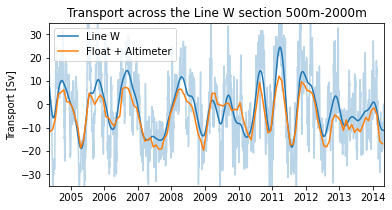

In [32]:
figure(figsize=(6,3))
# [axvspan(datetime.datetime(xx,1,1),datetime.datetime(xx,3,1),color='grey',alpha=0.6) for xx in range(2004,2015)];
LWmoor_trans=(LW.vg*LW.distdiff*LW.depthdiff/1e6).sel(depth=slice(500,2000)).sum(dim='dist').sum(dim='depth')
LWmoor_trans.plot(alpha=0.3)
plot(LW.date,smoothfunc(LWmoor_trans),color='C0',label='Line W')
# (LW_sm.vg*LW_sm.distdiff*LW_sm.depthdiff/1e6).sel(depth=slice(500,2000)).sum(dim='dist').sum(dim='depth').plot(label='Line W + SSH (smooth first)',linestyle='--')
Willis_LWtrans=LWplus.trans.swap_dims({'dist':'loni'}).sel(loni=slice(-71,-68.45)).sum(dim='loni').sel(depth=slice(500,2000)).sum(dim='depth')
Willis_LWtrans.plot(label='Float + Altimeter')
ylabel('Transport [Sv]')
legend(loc=2)
title('Transport across the Line W section 500m-2000m')
xlim(LW.date[0].values,LW.date[-1].values)
ylim(-35,35)
xlabel('')
xticks(rotation=0,ha='center')
# savefig(figdir+'LineW_WillisComp.pdf',bbox_inches='tight')
# savefig(figdir+'LineW_WillisComp.png',bbox_inches='tight',dpi=300)

In [33]:
LWmoor_trans.to_netcdf(datadir+'NASA_AMOC/LWtrans_moor.nc','w',format='netCDF4')
Willis_LWtrans.to_netcdf(datadir+'NASA_AMOC/LWtrans_Willis.nc','w',format='netCDF4')

In [34]:
LW.dist[-2]*1e3+LW.distdiff[-2]

<xarray.DataArray ()>
array(337221.99389876)
Coordinates:
    moor     <U2 'w5'
    lat      float64 38.1
    lon      float64 -68.65
    dist     float64 277.9

Interpolate LW mooring data to Willis product specs

In [35]:
# no longer needed as now using LW origin as section starting point
distcorr=gsw.distance([LW.lon_origin,LWplus.loni[0]],[LW.lat_origin,LWplus.lat[0]])[0]/1e3

In [36]:
LW_simple=LW_sm.drop('moor').rename({'lon':'loni'})
LW_simple['dist']=(['dist'],LW_sm['dist'].values+distcorr)
LW_simple=LW_simple.interpolate_na(dim='depth',fill_value='extrapolate',method='nearest')

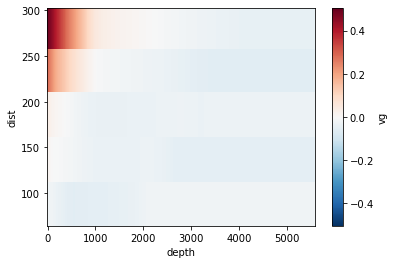

In [37]:
LW_simple.vg.mean(dim='date').plot()

In [38]:
LWinterp=LW_simple.interp(dist=LWplus.dist)
for var in ['vg','sigma2_i','rho_i']:
    LWinterp[var]=LWinterp[var].where(LWinterp.depth<-1*LWplus.bathy_i)

Now, stitch Line W moorings into Argo/sat product

In [39]:
d0=LW_simple.dist[0]
dE=LW_simple.dist[-1]

In [40]:
#LW weighted towards bottom/2000m, Willis towards surface
bathy_maxed=-1000
sfc_weight=((LWinterp.depth+bathy_maxed)/bathy_maxed+1).where(LWinterp.depth>1000,1).where(LWinterp.depth<2000,0)#.where(LWinterp.depth<-LWplus.bathy_i)
bot_weight=1-sfc_weight
LWstitch=xr.Dataset()
for var in ['vg','sigma2_i']:
    lin_merged=LWplus[var].sel(dist=slice(d0,dE)).interp(depth=LWinterp.depth)*sfc_weight+LWinterp[var].sel(dist=slice(d0,dE))*bot_weight
    ss=2000
    LWstitch[var]=xr.concat([lin_merged.sel(depth=slice(0,ss-1)),
                               LWinterp[var].sel(dist=slice(d0,dE)).sel(depth=slice(ss,LWinterp.depth.max()))],
                               dim='depth',coords='minimal',compat='override')

In [41]:
var='vg'

In [42]:
LWmerge=xr.Dataset()
for var in ['vg','loni','lat']:
    LWmerge[var]=xr.concat([LWplus[var].sel(dist=slice(0,LW_simple.dist[0])),LWstitch[var],LWplus[var].sel(dist=slice(LW_simple.dist[-1],LWplus.dist[-1]))],dim='dist',coords='minimal')
   #.sel(dist=slice(LW_simple.dist[0],LW_simple.dist[-1])) 

In [43]:
# no longer looking at times pre and post Line W
# quick cheat: fill sigma2 before and after Line W period so they can be used for LWplus transformation 
var='sigma2_i'
LWtime=xr.concat([LWplus[var].sel(dist=slice(0,LW_simple.dist[0])),LWstitch[var],LWplus[var].sel(dist=slice(LW_simple.dist[-1],LWplus.dist[-1]))],dim='dist',coords='minimal')
LWmerge[var]=xr.concat([LWplus.sigma2_i.sel(date=slice(LWplus.date[0],LW.date[0])),LWtime.sel(date=slice(LW.date[0],LW.date[-1])),LWplus.sigma2_i.sel(date=slice(LW.date[-1],LWplus.date[-1]))],dim='date')

/vortexfs1/home/ilebras/.conda/envs/OneEnv/lib/python3.8/site-packages/dask/array/core.py:2720: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [44]:
for var in ['bathy_i','depthdiff','distdiff']:
    LWmerge[var]=LWplus[var].copy()

In [45]:
LWmerge['depthdiff']=LWmerge['depthdiff'].where(~isnan(LWmerge.depthdiff),10)

In [46]:
LWmerge['trans']=LWmerge['vg']*LWmerge['distdiff']*LWmerge['depthdiff']/1e6

(-70.0, -65.0)

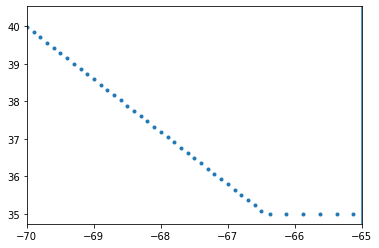

In [47]:
plot(LWplus.loni,LWplus.lat,'.')
axvline(-65)
xlim(-70,-65)

(-70.0, -65.0)

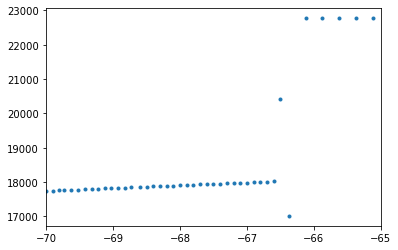

In [48]:
plot(LWmerge.loni,LWmerge.distdiff,'.')
xlim(-70,-65)

In [49]:
LWmerge=LWmerge.where(LWmerge.depth<(-1*LWmerge.bathy_i))

In [50]:
LWmerge['bathy_i']=LWmerge['bathy_i'].sel(depth=0)

In [51]:
LWmerge.to_netcdf(datadir+'NASA_AMOC/Section35N_Step1.nc','w',format='netCDF4')

In [ ]:
LWplus.to_netcdf(datadir+'NASA_AMOC/Section35N_Step1_noLW.nc','w',format='netCDF4')